# Term Deposit Marketing: Predicting Outcome Success

### Project Overview

**Goal:**  
Use machine learning to identify customers more likely to buy term deposits.

**Success Metric:**  
Optimize average precision (AUC-PR) to balance recall for likely buyers.


**Load Modules**

In [1]:
# Load Libraries and set directories
import pandas as pd
import numpy as np
import os
import sys
import shap
from sklearn.model_selection import train_test_split, StratifiedKFold,RepeatedStratifiedKFold
from sklearn.metrics import  confusion_matrix, ConfusionMatrixDisplay,classification_report,roc_curve, roc_auc_score, f1_score,average_precision_score
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
sys.path.append(os.path.expanduser('~/Documents/Apziva_projects'))
import feature_plots as fp

**Useful Functions**

In [2]:
def best_threshold(y_true, y_prob):
    thresholds = np.linspace(0, 1, 200) 
    scores = []
    for t in thresholds:
        y_pred = (y_prob >= t).astype(int)
        scores.append(f1_score(y_true, y_pred))
    best_idx = np.argmax(scores)
    return thresholds[best_idx]

def compare_auc_pr(models: dict, X_test, y_test):
    """
    models: dict like {"LogReg": lr, "RandomForest": rf, "XGB": xgb}
    X_test, y_test: holdout data
    """
    names, scores = [], []
    for name, mdl in models.items():
        y_score = mdl.predict_proba(X_test)[:, 1]
        ap = average_precision_score(y_test, y_score)
        names.append(name)
        scores.append(ap)

    # Bar chart
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.bar(names, scores)
    ax.set_ylabel("AUC-PR (Average Precision)")
    ax.set_xlabel("Model")
    ax.set_ylim(0, 1)

    # baseline: positive class prevalence
    baseline = float(np.mean(y_test))
    ax.axhline(baseline, linestyle="--")
    ax.text(-0.4, baseline + 0.01, f"Baseline={baseline:.3f}")

    # annotate bars
    for i, s in enumerate(scores):
        ax.text(i, s + 0.02, f"{s:.3f}", ha="center")

    plt.title("Model comparison: AUC-PR")
    plt.tight_layout()
    return dict(zip(names, scores))

def plot_roc_curves(models: dict, X_test, y_test):
    """
    models: {"LogReg": lr, "RandomForest": rf, "XGB": xgb}
    Returns dict of ROC-AUC per model.
    """
    plt.figure(figsize=(6, 5))
    aucs = {}

    for name, mdl in models.items():
        y_score = mdl.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_score)
        auc_val = roc_auc_score(y_test, y_score)
        aucs[name] = auc_val
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc_val:.3f})")

    # chance line
    plt.plot([0, 1], [0, 1], linestyle="--", label="Chance")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves by Model")
    plt.legend(loc="lower right")
    plt.tight_layout()
    return aucs

## Data Exploration

In [3]:
df = pd.read_csv("term-deposit-marketing-2020.csv")
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [4]:
df.y.value_counts()

y
no     37104
yes     2896
Name: count, dtype: int64

**Data Transformation**

In [5]:
df["default"] = df["default"].map({"yes": 1, "no": 0})
df["housing"] = df["housing"].map({"yes": 1, "no": 0})
df["loan"] = df["loan"].map({"yes": 1, "no": 0})
df["y"] = df["y"].map({"yes": 1, "no": 0})
df['age_log'] = np.log(df['age'] + 1)
df['duration_log'] = np.log(df['duration'] + 1)
df['month'] = df["month"].map({'jan':1, 'feb':2, 'mar':3, 'apr':4, 'may':5, 'jun':6, 'jul':7, 'aug':8, 'sep':9, 'oct':10, 'nov':11, 'dec':12})
df = df[df['contact'] != 'unknown']
df = df[df['education'] != 'unknown']
df = df[df['job'] != 'unknown']

In [37]:
df.describe()

,age,default,balance,housing,loan,day,month,duration,campaign,y,age_log,duration_log
count,26295.000000,26295.000000,26295.000000,26295.000000,26295.000000,26295.000000,26295.000000,26295.000000,26295.000000,26295.000000,26295.000000,26295.000000
mean,40.356570,0.019281,1304.010801,0.545579,0.184218,16.293364,6.295874,254.581631,2.901921,0.088040,3.695356,5.142245
std,9.688926,0.137514,3000.093812,0.497928,0.387669,8.146041,2.704425,261.030167,3.128301,0.283358,0.231351,0.932582
min,19.000000,0.000000,-8019.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,2.995732,0.000000
25%,33.000000,0.000000,56.000000,0.000000,0.000000,9.000000,5.000000,98.000000,1.000000,0.000000,3.526361,4.595120
50%,38.000000,0.000000,411.000000,1.000000,0.000000,17.000000,7.000000,172.000000,2.000000,0.000000,3.663562,5.153292
75%,48.000000,0.000000,1335.000000,1.000000,0.000000,21.000000,8.000000,313.000000,3.000000,0.000000,3.891820,5.749393
max,95.000000,1.000000,102127.000000,1.000000,1.000000,31.000000,12.000000,4918.000000,50.000000,1.000000,4.564348,8.500861


### Feature Visualization

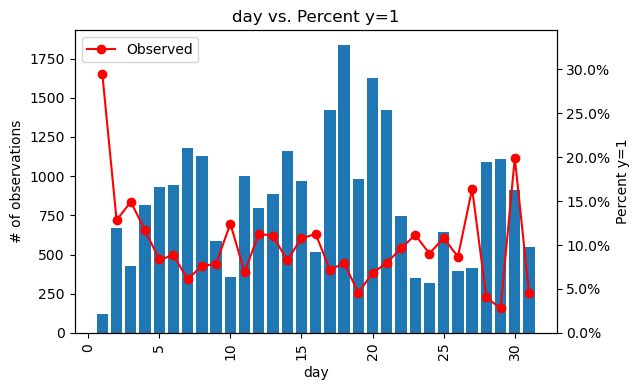

In [31]:
fp.plot_feature_vs_y(df,feature = 'day', y_col='y', dtype= 'cat', levels = list(range(1,32)), show_boxplot=False)

In [ ]:
#Check to ensure the values make sense
#Remove outliers by variable instead of general sweep
#Only remove outliers in training data

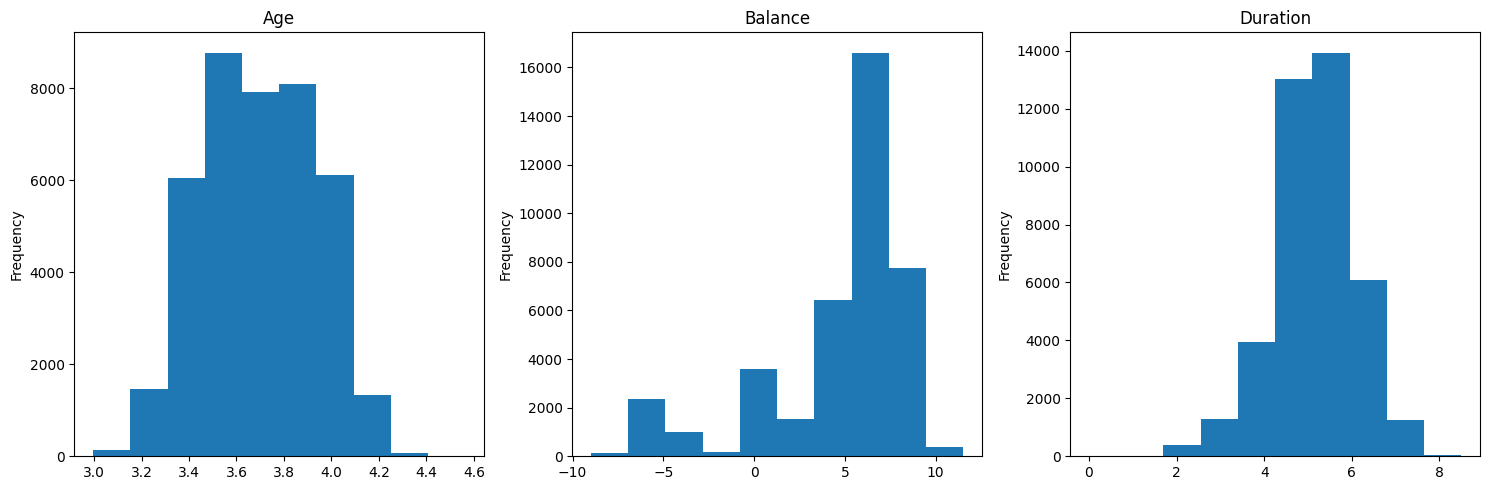

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
# Flatten axes for easy indexing
axes = axes.flatten()
df.age_log.plot.hist(ax=axes[0], title="Age")
df.balance_log.plot.hist(ax=axes[1], title="Balance")
df.duration_log.plot.hist(ax=axes[2], title="Duration")
plt.tight_layout()
plt.show()

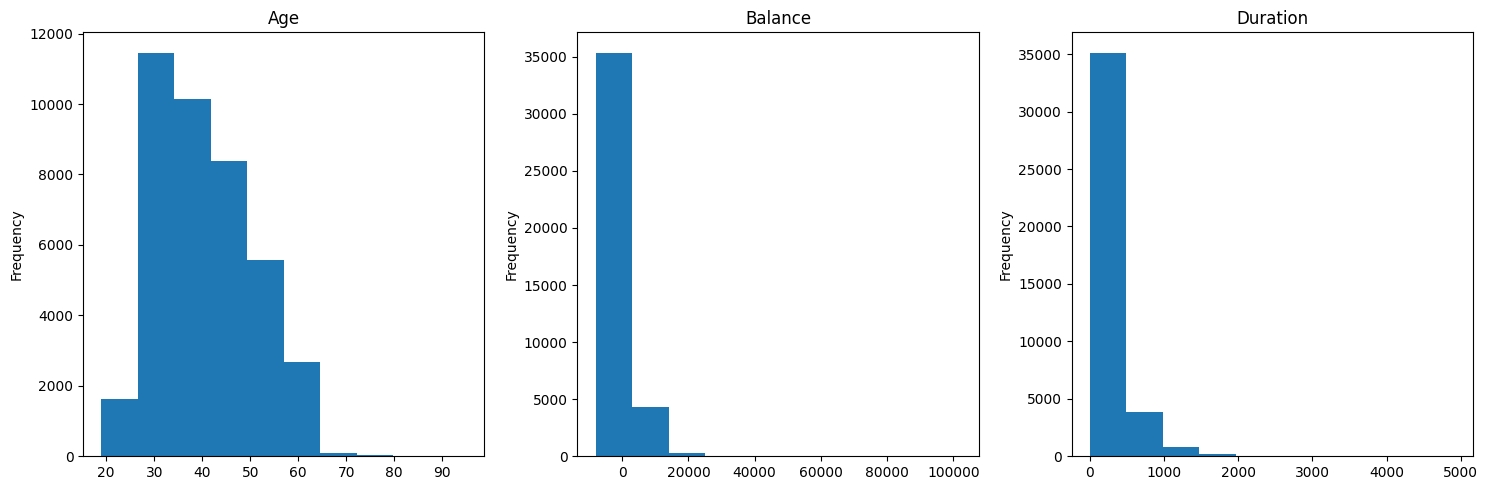

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
# Flatten axes for easy indexing
axes = axes.flatten()
df.age.plot.hist(ax=axes[0], title="Age")
df.balance.plot.hist(ax=axes[1], title="Balance")
df.duration.plot.hist(ax=axes[2], title="Duration")
plt.tight_layout()
plt.show()

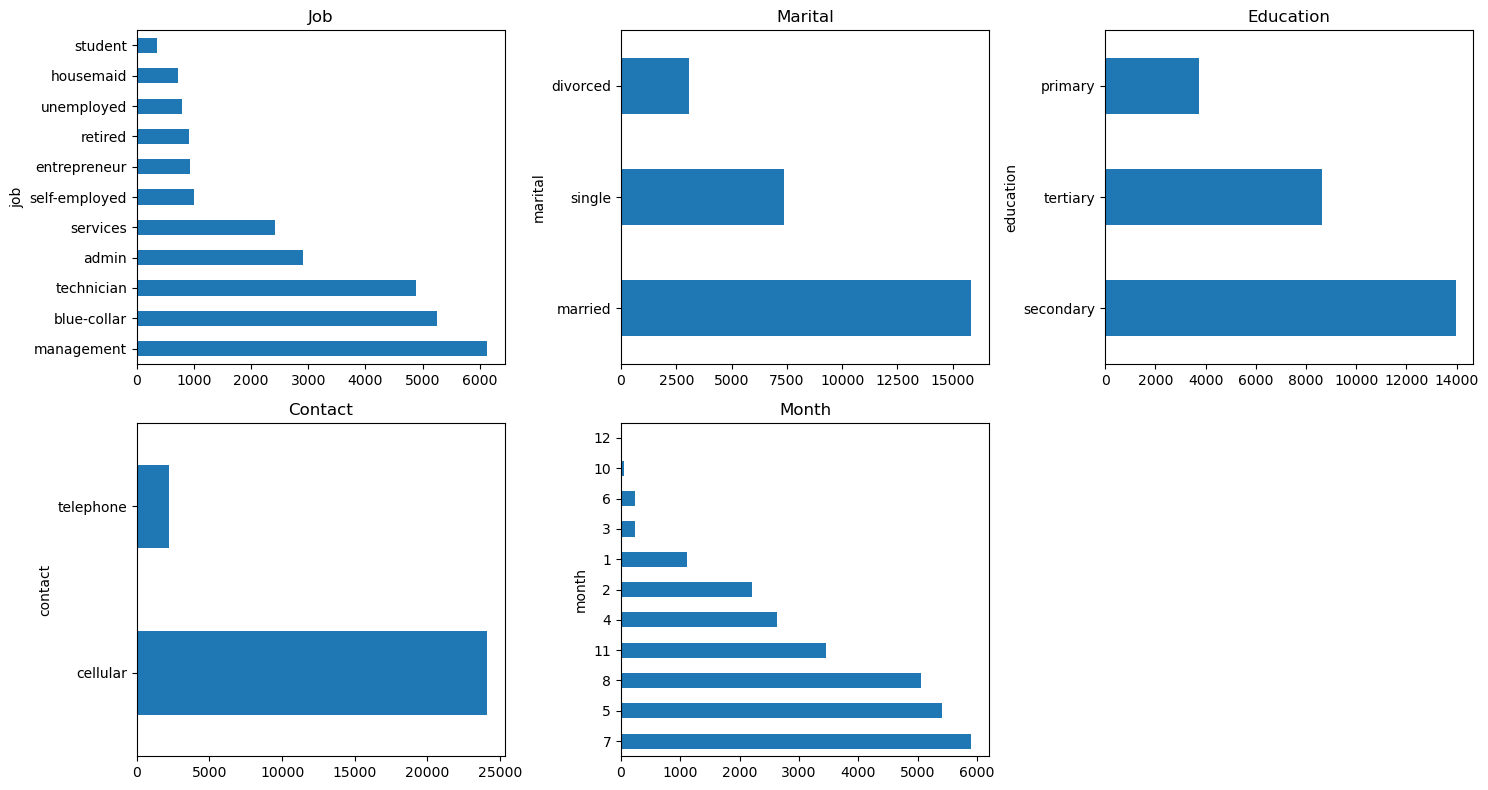

In [12]:
# Make a grid of 2 rows × 3 columns
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))

# Flatten axes for easy indexing
axes = axes.flatten()

df.job.value_counts().plot.barh(ax=axes[0], title="Job")
df.marital.value_counts().plot.barh(ax=axes[1], title="Marital")
df.education.value_counts().plot.barh(ax=axes[2], title="Education")
df.contact.value_counts().plot.barh(ax=axes[3], title="Contact")
df.month.value_counts().plot.barh(ax=axes[4], title="Month")

# Hide the unused subplot (6th slot)
axes[5].axis("off")


plt.tight_layout()
plt.show()

###Explore Variable relationships with Y

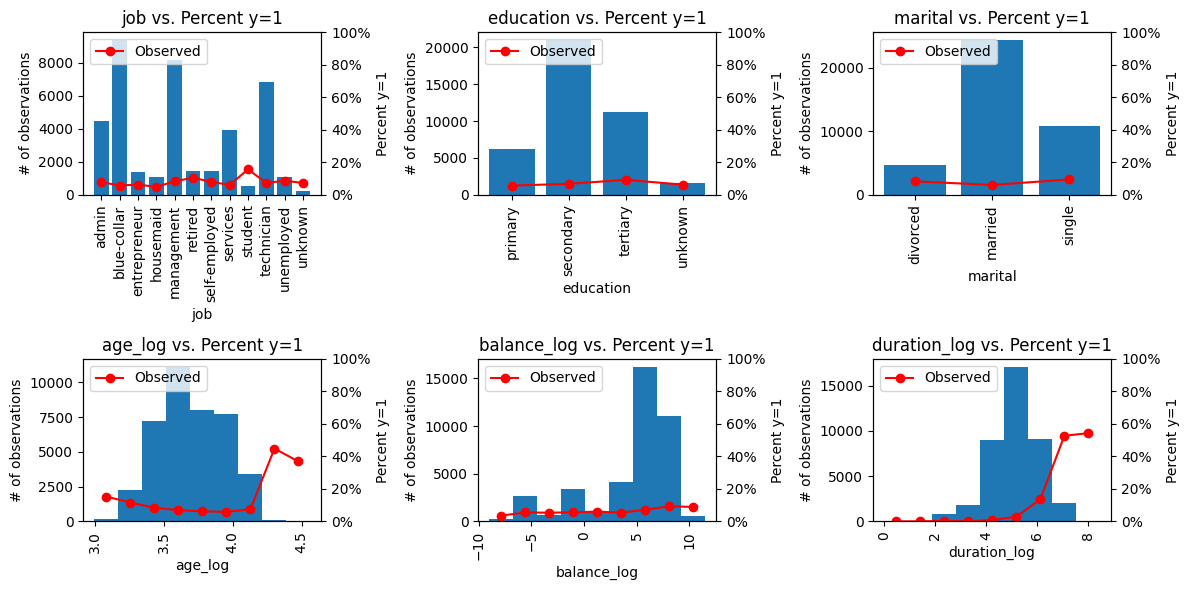

In [ ]:
# Grid of many features
fp.plot_features_vs_y_grid(
    df, ["job","education","marital","age_log","balance_log","duration_log"],
    y_col="y",
    dtype={"job":"cat","education":"cat","marital":"cat","age_log":"quant","balance_log":"quant","duration_log":"quant"},
    n_bins=9, cols=3, bin_method = "cut"
)


## Models

**Data_split**

In [6]:
y = df["y"]
X = df.drop(columns=["y","age", "duration"])
X.sample(5)

,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,age_log,duration_log
38753,blue-collar,single,secondary,0,171,1,0,cellular,18,5,2,3.367296,6.261492
26183,services,married,secondary,0,3992,1,0,telephone,20,11,2,3.737670,5.641907
26543,blue-collar,single,primary,0,258,1,0,cellular,20,11,1,3.583519,4.976734
36428,blue-collar,married,secondary,0,222,1,0,cellular,11,5,2,3.496508,5.700444
25294,blue-collar,married,secondary,0,1070,0,0,cellular,18,11,4,4.007333,5.924256


In [7]:
#Preprocessing Data
# cat = ["job_combined","education","marital","contact","balance_cat"]
cat = ["job", "education","marital","contact"]
#OneHot Encoding

ct = ColumnTransformer(
    [('one_hot', OneHotEncoder(dtype='float'), cat)],
    remainder='passthrough', verbose_feature_names_out=False)

X_hot_encode = ct.fit_transform(X)
hot_encode_names = ct.get_feature_names_out().tolist()
X_hot_encode = pd.DataFrame(X_hot_encode, columns=hot_encode_names)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_hot_encode, y, test_size=0.20, random_state=42)


## Logistic Regression

In [9]:
# Linear Regresssion - original
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty='elasticnet', solver= 'saga', C=1, l1_ratio=0.5, max_iter=5000,class_weight="balanced")
lr.fit(X_train, y_train)
y_prob_test = lr.predict_proba(X_test)[:, 1]
threshold = best_threshold(y_test, y_prob_test)
print(threshold)
y_pred_test = (y_prob_test >= threshold).astype(int)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


0.49748743718592964


In [10]:
print("Test Metrics")
print(classification_report(y_test, y_pred_test))

Test Metrics
              precision    recall  f1-score   support

           0       0.93      0.68      0.79      4808
           1       0.12      0.49      0.20       451

    accuracy                           0.66      5259
   macro avg       0.53      0.58      0.49      5259
weighted avg       0.86      0.66      0.74      5259



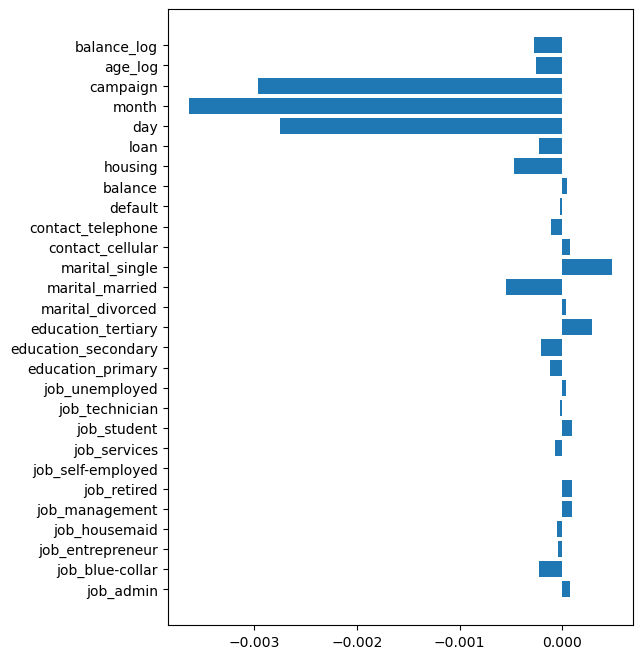

In [17]:
plt.figure(figsize=(6, 8))
plt.barh(hot_encode_names, lr.coef_[0])
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


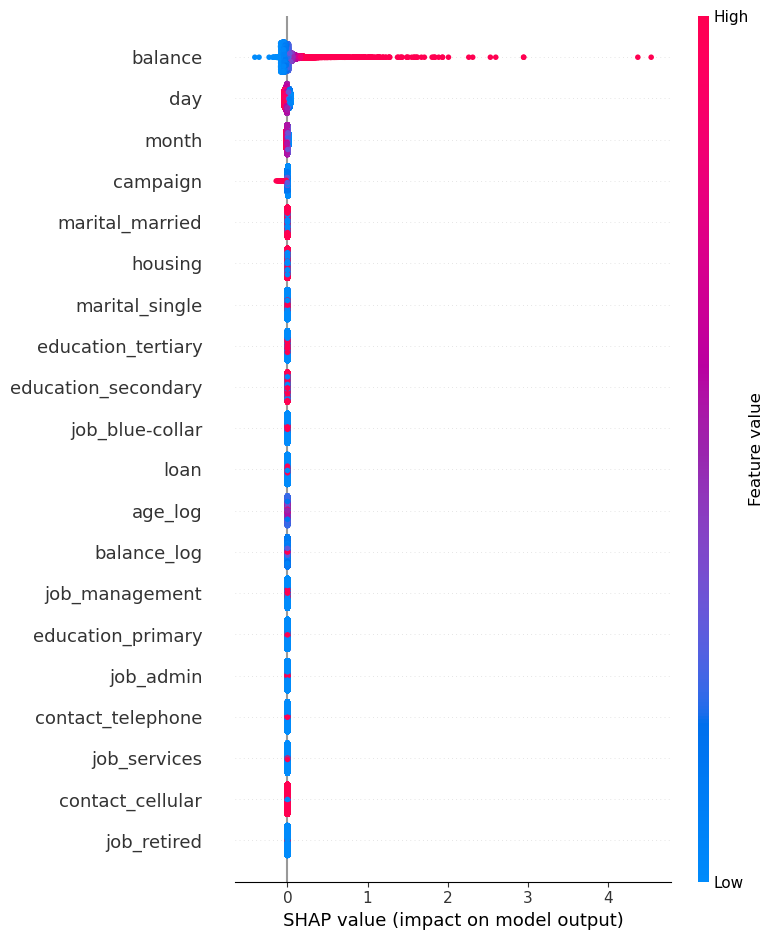

In [21]:
# SHAP values for Logistic Regression
explainer = shap.LinearExplainer(lr, X_hot_encode, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_hot_encode)

shap.summary_plot(shap_values, X_hot_encode)

## XGBoost

In [22]:
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.metrics import make_scorer, average_precision_score

model = XGBClassifier(
    objective="binary:logistic",
    max_delta_step=1,
    scale_pos_weight = 12.6,
    eval_metric="logloss"
)
pr_auc_scorer = make_scorer(average_precision_score,  response_method="predict_proba", pos_label=1)
param_dist = {
    "learning_rate": np.logspace(-3, 0, 20),     # 0.001 to 1
    "max_depth": [3, 4, 5, 6, 7, 8],             # tree depth
    "min_child_weight": [1, 5, 10],              # minimum sum of weights
    "subsample": [0.6, 0.8, 1.0],                # row sampling
    "colsample_bytree": [0.6, 0.8, 1.0],         # feature sampling
    "gamma": np.linspace(0, 5, 10),
    "n_estimators": np.arange(200, 2000, 200)
}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)

halving_search = HalvingRandomSearchCV(
    estimator=model,
    param_distributions=param_dist,
    factor=3,              # resource multiplier each round
    random_state=1,
    cv=cv,
    scoring= pr_auc_scorer,
    n_jobs=-1,
    verbose=1
)

halving_result = halving_search.fit(X_hot_encode, y)

print("Best: %f using %s" % (halving_result.best_score_, halving_result.best_params_))


NameError: name 'RepeatedStratifiedKFold' is not defined

In [11]:
# Final XGBoost model
xg = XGBClassifier(learning_rate= 0.2, objective='binary:logistic',gamma = 0.26,max_delta_step=1, scale_pos_weight=12.6)
xg.fit(X_train, y_train)
y_prob_test = xg.predict_proba(X_test)[:, 1]
threshold = best_threshold(y_test, y_prob_test)
print(threshold)
y_pred_test = (y_prob_test >= threshold).astype(int)

0.7035175879396985


In [12]:
print("Test Metrics")
print(classification_report(y_test, y_pred_test))

Test Metrics
              precision    recall  f1-score   support

           0       0.97      0.93      0.95      4808
           1       0.51      0.73      0.60       451

    accuracy                           0.92      5259
   macro avg       0.74      0.83      0.78      5259
weighted avg       0.93      0.92      0.92      5259



Test


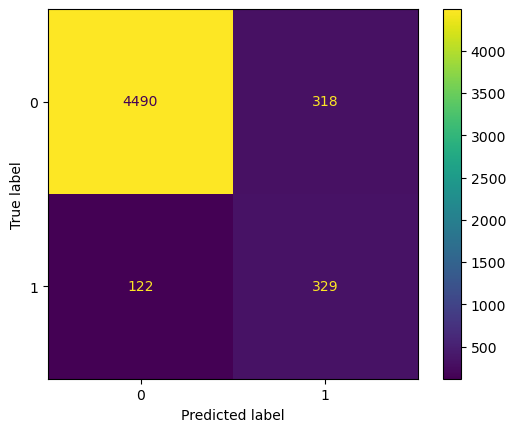

In [14]:
print("Test")
cm_test = confusion_matrix(y_test, y_pred_test)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=xg.classes_)
disp_test.plot()
plt.show()

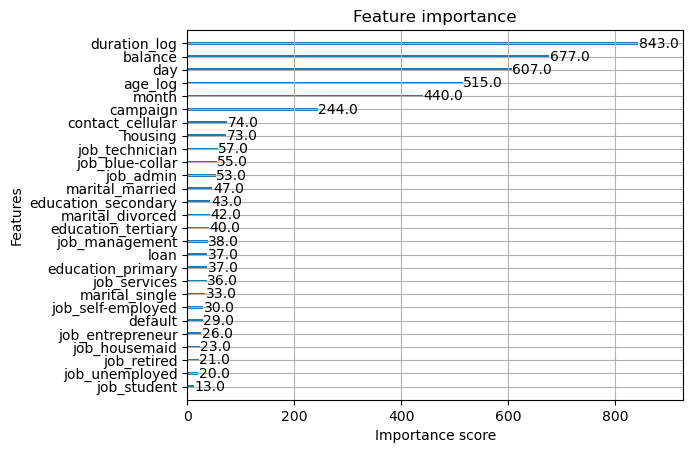

In [15]:
#AUC/ROC
#Predicted vs. Observed
xg.get_booster().feature_names = hot_encode_names
plot_importance(xg.get_booster())
plt.show()

In [16]:
import shap
# X_hot_encode = pd.DataFrame(X_hot_encode, columns=hot_encode_names)
explainer = shap.Explainer(xg)
shap_values = explainer(X_test)
shap.initjs()

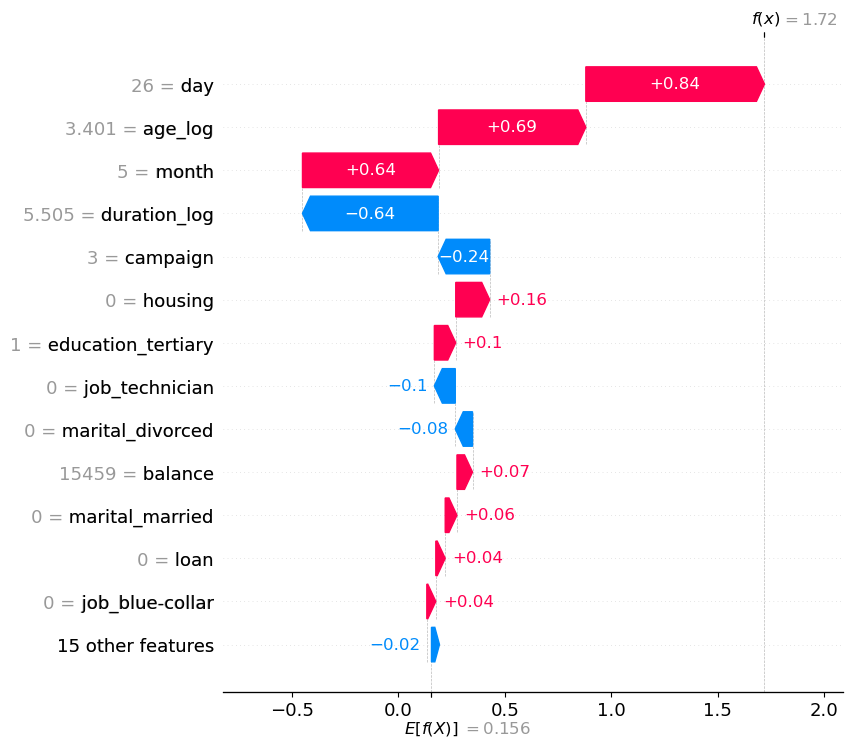

In [17]:
shap.plots.waterfall(shap_values[0], max_display=14)


In [ ]:
ax = shap.plots.waterfall(shap_values[0], max_display=14, show=False)
fig = ax.figure
fig.savefig("waterfall_plot_xg.png", dpi=300, bbox_inches="tight")
plt.close(fig)

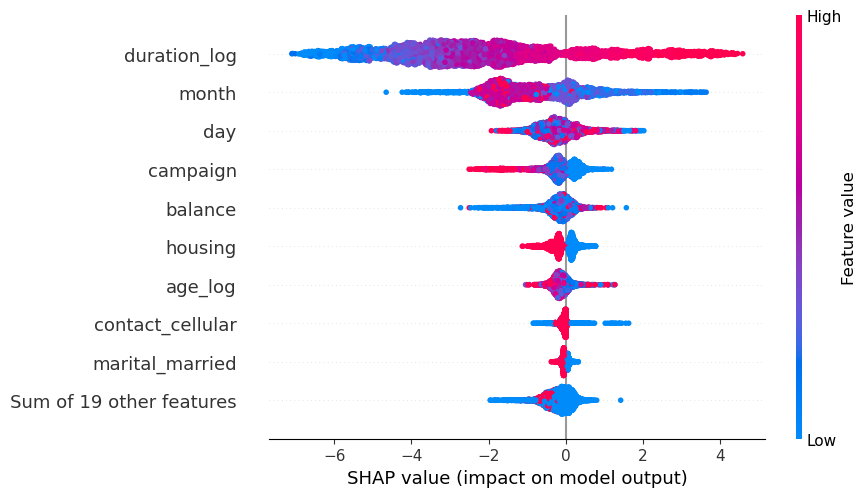

In [18]:
shap.plots.beeswarm(shap_values)

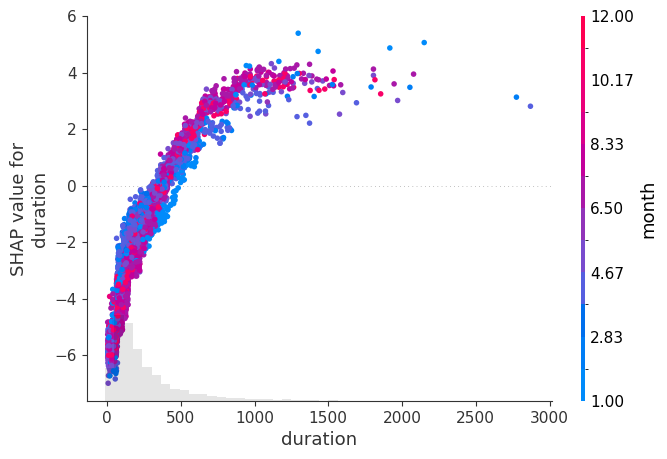

In [82]:
shap.plots.scatter(
    shap_values[:, "duration"],     
    color=shap_values               
)

plt.show()

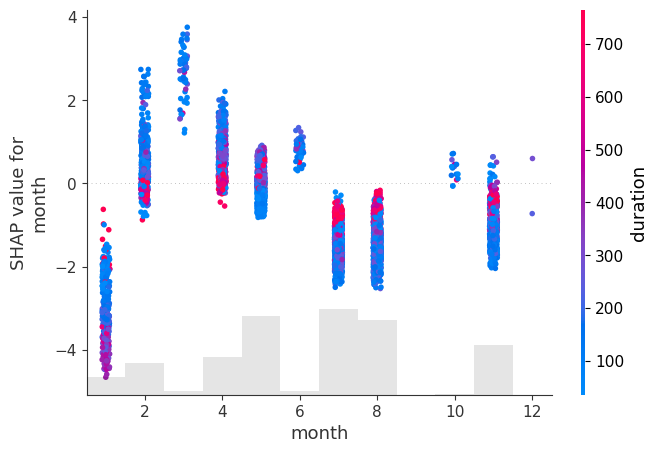

In [83]:
shap.plots.scatter(
    shap_values[:, "month"],     
    color=shap_values               
)

plt.show()

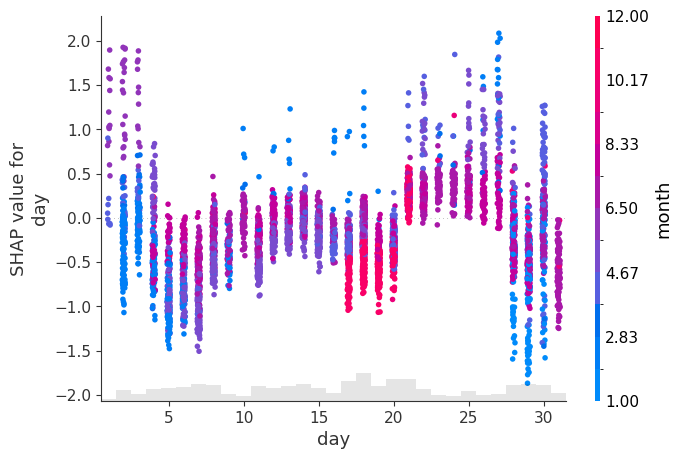

In [14]:
shap.plots.scatter(
    shap_values[:, "day"],     
    color=shap_values               
)

plt.show()

### Random Forest

In [19]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings("ignore", message="No positive class found in y_true")


param_distributions = {
    "n_estimators": np.arange(200, 1000, 200),          # more trees; RF variance drops then plateaus
    "max_depth": [None, 8, 12, 16, 20, 24],              # shallow→deep
    "min_samples_split": [2, 5, 10, 20],                # regularization
    "min_samples_leaf": [1, 2, 4, 8],           
    "max_features": ["sqrt", "log2", 0.3, 0.5, 0.7],    # try categorical + fractions\
    "max_samples": [None, 0.5, 0.7, 0.9]              # with bootstrap=True; speeds training
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

search = RandomizedSearchCV(
    RandomForestClassifier(
        n_jobs=-1,
        bootstrap=True,
        oob_score=True, 
    ),
    param_distributions=param_distributions,
    cv=cv,
    scoring="average_precision",
    random_state=42
)

search.fit(X_train, y_train)
print("Best Parameters:", search.best_params_)
print("Best Estimator:", search.best_estimator_)


Best Parameters: {'n_estimators': 600, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.5, 'max_features': 0.5, 'max_depth': 24}
Best Estimator: RandomForestClassifier(max_depth=24, max_features=0.5, max_samples=0.5,
                       min_samples_leaf=4, min_samples_split=5,
                       n_estimators=600, n_jobs=-1, oob_score=True)


In [21]:
rf = RandomForestClassifier(max_depth=24, max_features=0.5, max_samples=0.5,
                       min_samples_leaf=4, min_samples_split=5,
                       n_estimators=600, n_jobs=-1, oob_score=True)
rf.fit(X_train, y_train)

y_prob_test = rf.predict_proba(X_test)[:, 1]
threshold = best_threshold(y_test, y_prob_test)
print(threshold)
y_pred_test = (y_prob_test >= threshold).astype(int)

0.2814070351758794


In [22]:
y_pred_test = rf.predict(X_test)
print("Test Metrics")
print(classification_report(y_test, y_pred_test))

Test Metrics
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      4808
           1       0.59      0.41      0.49       451

    accuracy                           0.93      5259
   macro avg       0.77      0.69      0.72      5259
weighted avg       0.92      0.93      0.92      5259



In [23]:
import eli5
eli5.show_weights(rf, feature_names = hot_encode_names)

Weight,Feature
0.4802 ± 0.0454,duration_log
0.1022 ± 0.0333,day
0.0954 ± 0.0291,balance
0.0912 ± 0.0335,month
0.0842 ± 0.0289,age_log
0.0316 ± 0.0158,campaign
0.0244 ± 0.0162,housing
0.0103 ± 0.0088,education_tertiary
0.0100 ± 0.0087,marital_married
0.0086 ± 0.0085,marital_single


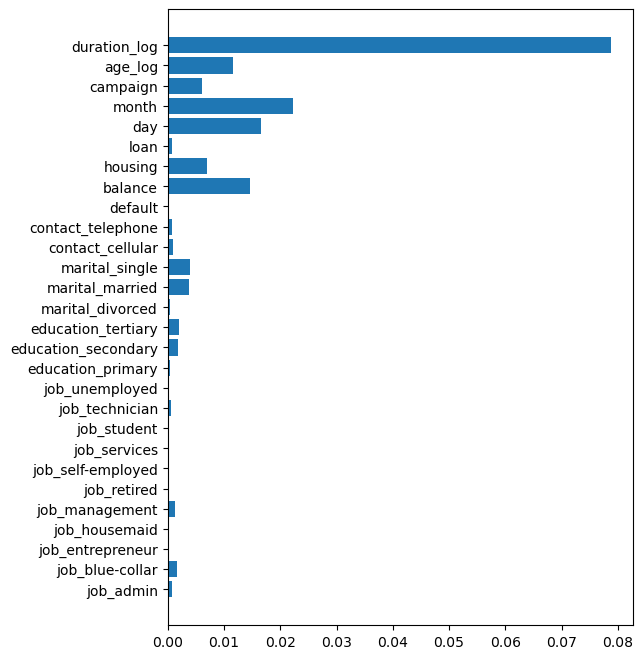

In [24]:
from eli5.sklearn import PermutationImportance
perm = PermutationImportance(rf, cv = None, refit = False).fit(X_train, y_train)

plt.figure(figsize=(6, 8))
plt.barh(hot_encode_names, perm.feature_importances_)
plt.show()

**Model Selection**

{'LogReg': 0.11746492640696274, 'RandomForest': 0.5374169427567124, 'XGB': 0.5696586468697438}


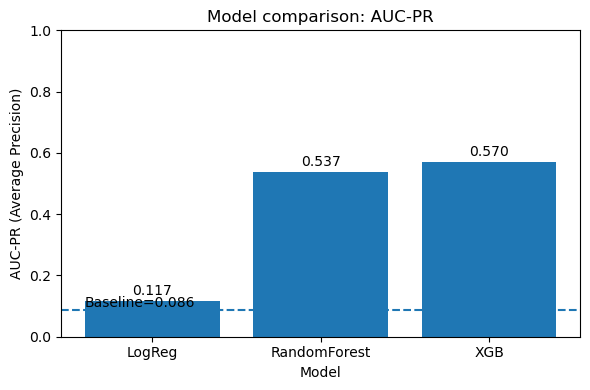

In [25]:
results = compare_auc_pr({"LogReg": lr, "RandomForest": rf, "XGB": xg}, X_test, y_test)
print(results)

{'LogReg': 0.6109260803317457, 'RandomForest': 0.9382256475718592, 'XGB': 0.9385438533707678}


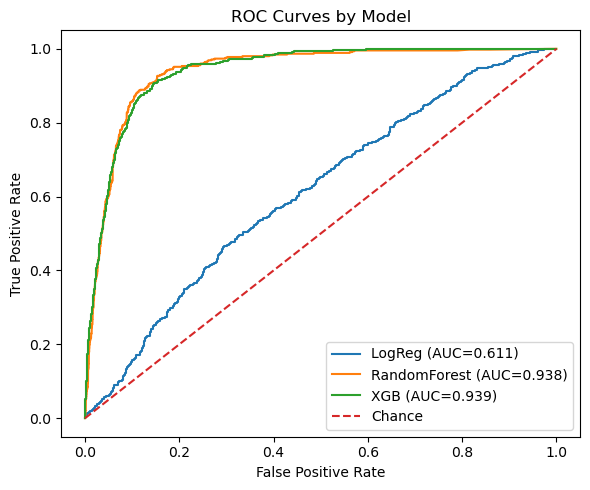

In [26]:
aucs = plot_roc_curves({"LogReg": lr, "RandomForest": rf, "XGB": xg}, X_test, y_test)
print(aucs)